# Evaluacón de modelos

In [1]:
import joblib
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model._logistic import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


from config import MODELS_PATH

In [2]:
MODELS = os.path.join(MODELS_PATH, "refit")
TESTSETS = os.path.join(MODELS_PATH, "testsets")

In [3]:
models_predictions = dict()

for model in os.listdir(MODELS):
    if model.startswith("svm"):
        continue
    name, _ = os.path.splitext(model)
    _, dataset = name.split("_")

    dataset_path = os.path.join(TESTSETS, F"X_test_{dataset}.csv")
    X = pd.read_csv(dataset_path)

    model_path = os.path.join(MODELS, model)
    trained_model = joblib.load(model_path)
    predictions = {"y_hat": trained_model.predict(X)}

    for method in ["predict_proba", "predict_log_proba", "predict_joint_log_proba"]:
        if hasattr(trained_model, method):
            key = method.replace("predict_", "").strip()
            predictions.update(
                {f"y_hat_{key}": getattr(trained_model, method)(X)}
            )

    models_predictions[name] = predictions

In [4]:
for key, value in models_predictions.items():
    print("{0:18} --- {1}".format(key, list(value.keys())))

lr_proporciones    --- ['y_hat', 'y_hat_proba', 'y_hat_log_proba']
nb_proporciones    --- ['y_hat', 'y_hat_proba', 'y_hat_log_proba', 'y_hat_joint_log_proba']


## Reportes

In [5]:
y_path = os.path.join(TESTSETS, "y_test.csv")
y = pd.read_csv(y_path, header=None)

In [6]:
report = dict()

for key, value in models_predictions.items():
    model, dataset = key.split("_")
    print(f"Reporte para modelo {model} con dataset {dataset}")
    print(classification_report(y, value["y_hat"]))
    report[key] = classification_report(y, value["y_hat"], output_dict=True)

Reporte para modelo lr con dataset proporciones
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.74      0.77      0.76        22

    accuracy                           0.73        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.72      0.72      0.72        40

Reporte para modelo nb con dataset proporciones
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        18
           1       0.83      0.68      0.75        22

    accuracy                           0.75        40
   macro avg       0.76      0.76      0.75        40
weighted avg       0.77      0.75      0.75        40



## Visualizaciones

In [65]:
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(10,7))
    vmin, vmax = 0, int(cm.sum()/2)
    ticks = list(range(vmin, vmax+1, 2))
    sns.heatmap(
        cm, annot=True, cmap="crest", alpha=.7, ax=ax,
        vmin=vmin, vmax=vmax,
        annot_kws={"color":"black", "size": 12},
        cbar_kws={"ticks": ticks},
        xticklabels=["En contra", "A favor"], yticklabels=["En contra", "A favor"]
    )
    ax.set_title(title)
    ax.set_xlabel("Valores predichos")
    ax.set_ylabel("Valores esperados")
    plt.show()

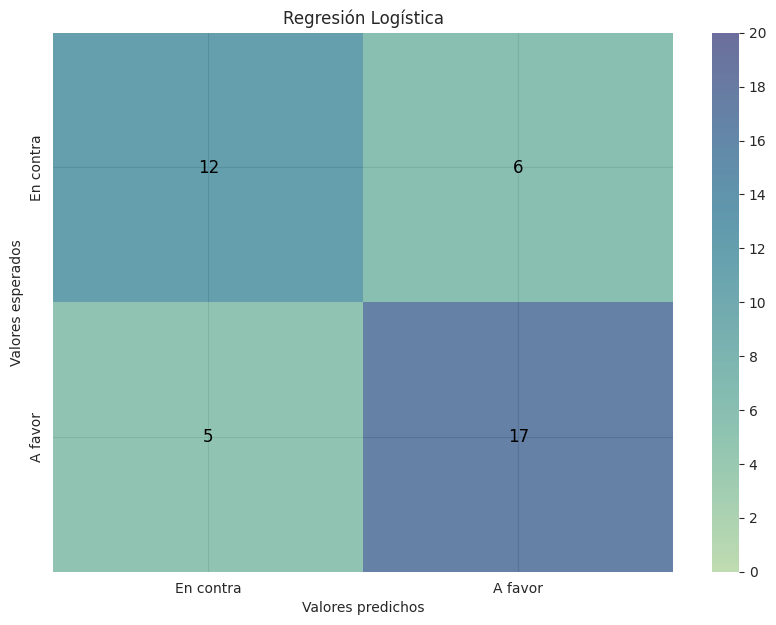

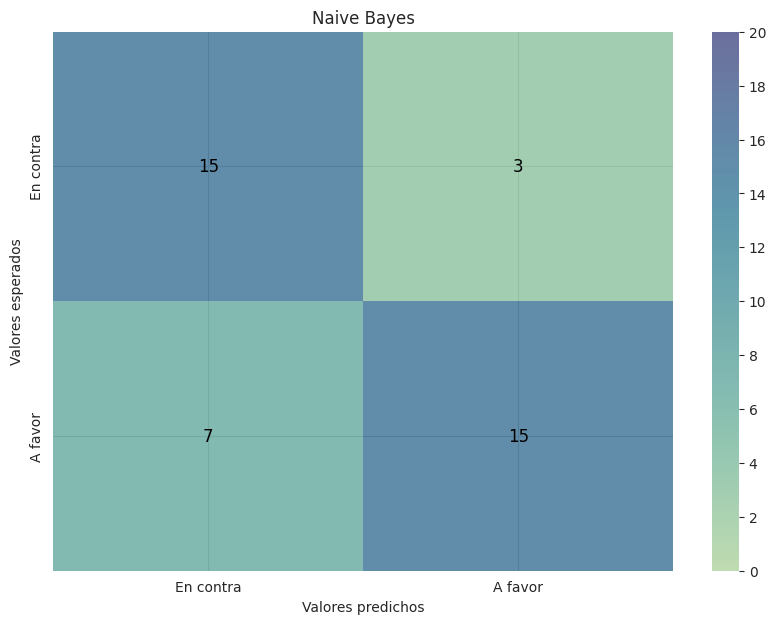

In [66]:
titles = {"nb": "Naive Bayes", "lr": "Regresión Logística"}

for key, value in models_predictions.items():
    model, dataset = key.split("_")
    cm = confusion_matrix(y, value["y_hat"])
    title = titles.get(model)
    plot_confusion_matrix(cm, title=title)